# So What is a Jupyter Notebook?
_The Jupyter Notebook is a web application for interactive data science and scientific computing. It allows users to author documents that combine live-code with narrative text, equations, images, video and visualizations._

source: https://jupyter.readthedocs.org/en/latest/

#So... what is it? -- It's Python (or other language) in your web browser. 
Jupyter is the evolution of the IPython Notebook. 

## Advantages
- **Instant Gratification with Data Discovery**
    - _Who wants/has time to sift through JPGs? Or organize open windows to view charts side-by-side?_
- **Story Telling with Data**
    - _Narate your graphs, maps, visualizations, equations, etc_
- **Multiple Language Intergration**
    - _Python missing a key statistical method (becoming less likely, Dan)? Swith to R or Matlab or Julia or any other 48 someting supported languages_
- **It's a server, meaning you can connect to remote servers**
    - _If data is stored on external server, keep it there and still work locally!_
- **Packaged with Anaconda - quick and easy to get started**
    - _Great way for beginners to get started - think, no complicated IDE and just enough interaction to be more useful than a text editor_
- **Collaboration**
    - _Use with Github_
        - _If data is small enough, store in Git; if not, store in a database or other cloud option to make collaboration even easier_
    - _Standardize data visualizations of model outputs_
    - _Share via http://nbviewer.ipython.org_
- **Reproducable Research**
    - _Give someone your Notebook and data and they can instantly reproduce your results_
    - _Becoming standard in the scientific community_

## Disadvantages
- **Missing my IDE**
    - _Can't say that I'd fully replace my IDE with it..._
    - _Debug is nice to have_
    - _Code inspection can be very helpful in complex code_
    
# How is NREL Using Jupyter?
- Collaborative reporting tool for agent-based diffusion models and electricity capacity expansion models
- Model/data diagnostics for solar resource assessment - direct link to > 50 TB of data on NRELs High Performance Computer
- Rewewable energy supply curve regional and cost breakdown visualizations
- Other random acts of visualization

### Enough Talk, Let's Step Through an Example

# Solar Energy Potential for Front Range Cities
How much energy can Colorado cities harness from the sun? This quick demo will explore and try to answer this question using basic GIS technology with some energy modeling software. 

**NOTICE:** Don't get caught up in the solar domain jargin, concentrate on the flow of the analysis

In [1]:
# do some imports...
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import psycopg2
import json
import urllib2

In [2]:
# import System Advisor Model SSC...
import site
site.addsitedir('/Users/alopez/Applications/sam-sdk-2015-6-30-r2/languages/python')
import sscapi
ssc = sscapi.PySSC()

In [6]:
# create connection to postgres database
conn = psycopg2.connect('dbname=alopez user=alopez host=localhost password=alopez')

## What is the Potential Solar Capacity (MW) for Front Range Cities?
What is the solar potential for Colorado cities? We can use a grid that has available land for solar development (technical potential) and intersect with city boundaries to find out. Nothing special here, just some basic GIS.

__Data Needs:__
 - Land Available for Solar Development
 - City Boundaries

In [7]:
# perform spatial intersection between urban areas and solar potential grid
sql = '''SELECT a.name, SUM(b.pv_tech_pot) * 35 AS "MW"
         FROM urban a
         INNER JOIN grid b ON ST_Intersects(a.the_geom_4326, b.the_geom_4326)
         WHERE a.name IN ('Denver--Aurora', 'Fort Collins', 'Pueblo', 'Colorado Springs', 'Greeley', 'Boulder')
         GROUP BY a.name;'''
df_cap = pd.read_sql(sql, conn)

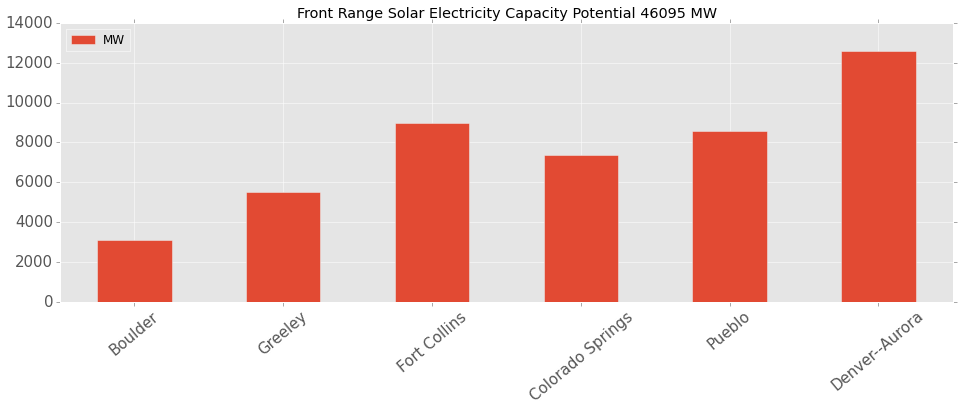

In [8]:
# graph results
ax = df_cap.plot(kind='bar', figsize=(16,5), fontsize=15, 
        title='Front Range Solar Electricity Capacity Potential {s} MW'.format(s=df_cap['MW'].sum()))
_ = ax.set_xticklabels(df_cap['name'], rotation=40)

## What's the Potential Generation (TWh) of Colorado Cities?
Let's pick one one solar resource profile for each Colorado city (solar resource has high spatial autocorrelation, besides.. this is just a demo!) and estimate how much electric generation we could get. 

**Data Needs:**
- Hourly solar and meteorological profiles for each city
- Electric capacity potential for each city

In [9]:
# hello SAM. SAM function for estimating solar energy
def sam_run(df, lon, lat):
    # resource inputs
    wfd = ssc.data_create()
    ssc.data_set_number(wfd, 'lat', lat)
    ssc.data_set_number(wfd, 'lon', lon)
    ssc.data_set_number(wfd, 'tz', -7)
    ssc.data_set_number(wfd, 'elev', 1800)
    ssc.data_set_array(wfd, 'year', df.index.year)
    ssc.data_set_array(wfd, 'month', df.index.month)
    ssc.data_set_array(wfd, 'day', df.index.day)
    ssc.data_set_array(wfd, 'hour', df.index.hour)
    ssc.data_set_array(wfd, 'minute', df.index.minute)
    ssc.data_set_array(wfd, 'dn', df['DNI'])
    ssc.data_set_array(wfd, 'df', df['DHI'])
    ssc.data_set_array(wfd, 'wspd', df['Wind Speed'])
    ssc.data_set_array(wfd, 'tdry', df['Temperature'])

    dat = ssc.data_create()
    ssc.data_set_table(dat, 'solar_resource_data', wfd)
    ssc.data_free(wfd)

    # System Config
    ssc.data_set_number(dat, 'system_capacity', 1000)
    ssc.data_set_number(dat, 'dc_ac_ratio', 1.1)
    ssc.data_set_number(dat, 'tilt', 25)
    ssc.data_set_number(dat, 'azimuth', 180)
    ssc.data_set_number(dat, 'inv_eff', 96)
    ssc.data_set_number(dat, 'losses', 14.0757)
    ssc.data_set_number(dat, 'array_type', 0)
    ssc.data_set_number(dat, 'gcr', 0.4)
    ssc.data_set_number(dat, 'adjust:constant', 0)

    # execute and stuff results back into df
    mod = ssc.module_create('pvwattsv5')
    ssc.module_exec(mod, dat)
    generation = np.array(ssc.data_get_array(dat, 'gen'))
    
    # free the memory
    ssc.data_free(dat)
    ssc.module_free(mod)
    
    return generation

In [10]:
# Select One Location for Each Urban Area
sql = '''SELECT DISTINCT ON (a.name) a.name, ST_X(ST_Centroid(a.the_geom_4326)) AS lon, ST_Y(ST_Centroid(a.the_geom_4326)) AS lat 
         FROM urban a
         INNER JOIN grid b ON ST_Intersects(a.the_geom_4326, b.the_geom_4326)
         WHERE a.name IN ('Denver--Aurora', 'Fort Collins', 'Pueblo', 'Colorado Springs', 'Greeley', 'Boulder')'''
results = pd.read_sql(sql, conn)

# Store Results from SAM in Here
df_gen = pd.DataFrame(columns=['name', 'kWh'])
year = 2005
for i, row in results.iterrows():
    # API Call (well would be..) to Download Solar Resource Data
    wf = pd.read_csv('./data/{lon}_{lat}_{year}.csv'.format(lon=row['lon'], lat=row['lat'], year=year))
    
    # Set the time index in the pandas dataframe
    wf = wf.set_index(pd.date_range('1/1/{yr}'.format(yr=year), tz='US/Mountain', freq='1h', periods=8760))

    # Execute SAM Model Run
    gen = sam_run(wf, row['lon'], row['lat'])
    
    #Gather Results
    df_gen = pd.concat([df_gen, pd.DataFrame({'name': [row['name']], 'kWh': [gen.sum()]})])

# determine the system performance
df_gen['capacity factor'] = df_gen['kWh'] / (8760 * 1000) 

In [11]:
# Last Step. Join Capacity Factor Data with Capacity to Determine Generation
df = pd.merge(df_cap, df_gen, on='name')
df['Total TWh'] = (df['MW'] * 8760 * df['capacity factor']) / 1000000.

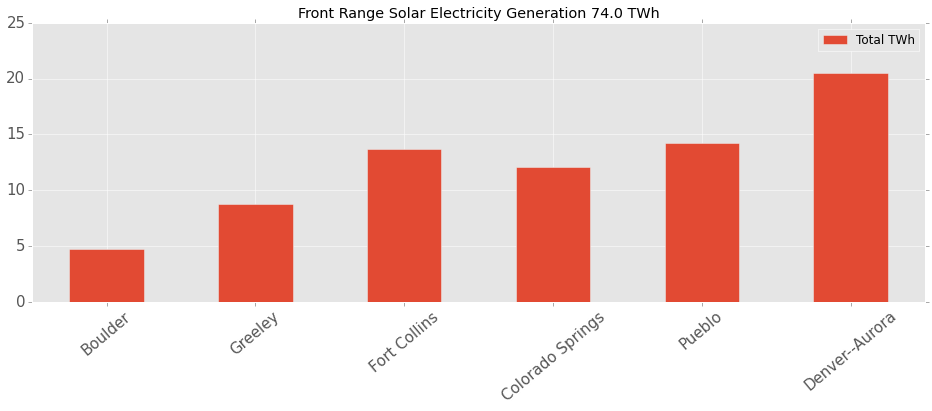

In [12]:
# graph results
ax = df[['name', 'Total TWh']].plot(kind='bar', figsize=(16,5), fontsize=15, 
        title='Front Range Solar Electricity Generation {g} TWh'.format(g=round(df['Total TWh'].sum())))
_ = ax.set_xticklabels(df['name'].values, rotation=40)

## So How Does this Compare to Current Energy Use?
Let's grab some data from the Energy Information Administration using their web API. Web API's are your friend. They take the storage component of using data out of your wheelhouse. 

In [13]:
url = 'http://api.eia.gov/series/?api_key=78C213EA8D7ACC72A0296C69B88EC160&series_id=SEDS.ESRCP.CO.A'
j = urllib2.urlopen(url).read()
eia = np.array(json.loads(j[3:])['series'][0]['data'])
eia = pd.DataFrame({'Historic Consumption (TWh)' : eia[:, 1].astype(np.float) / 1000., 
                    'Potential Generation (TWh)': df['Total TWh'].sum()}, index=eia[:, 0]).sort()

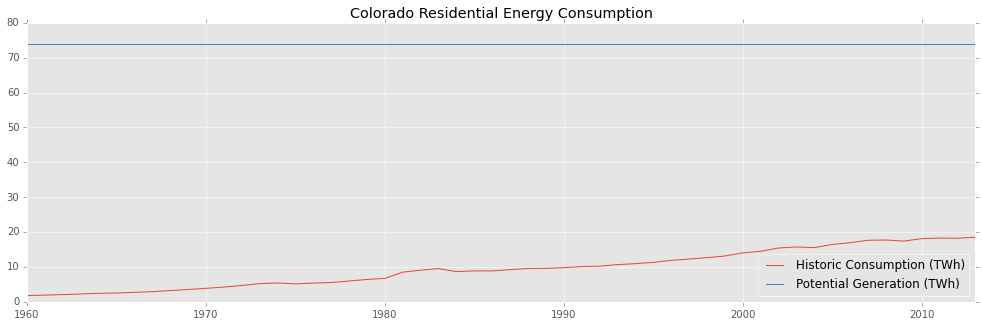

In [14]:
ax = eia.plot(figsize=(17, 5), title='Colorado Residential Energy Consumption')

## Well That Looks Like Good News. We have Enough Energy to Last a Long Time. 
But wait... that was only one year of data, plainly speaking, the sun don't shine the same year-after-year, does it? 

Nope. So let's take a closer look at Denver. What's the interannual variability of solar and what does this mean for Denver's energy potential? We can use a measure called p50, which gives us a generation number with a 50% probability of happening every year. Since solar is non-normal, we determine probabilities using an empirical cumulative distribution function (ECDF)

In [15]:
# iterate over each year, get data, run in SAM
denver = results[results['name'] == 'Denver--Aurora']

pN = pd.DataFrame(columns=['year', 'kWh'])
for year in range(2005, 2013):
    # read weather data
    wf = pd.read_csv('./data/{lon}_{lat}_{year}.csv'.format(lat=denver['lat'].iloc[0], lon=denver['lon'].iloc[0], year=year))
    
    # Set the time index in the pandas dataframe
    wf = wf.set_index(pd.date_range('1/1/{yr}'.format(yr=year), tz='US/Mountain', freq='1h', periods=8760))

    # Execute SAM Model Run
    gen = sam_run(wf, denver['lon'], denver['lat'])
    
    #Gather Results
    pN = pd.concat([pN, pd.DataFrame({'year': [year], 'kWh': [gen.sum()]})])

# determine the system performance by year
pN['capacity factor'] = pN['kWh'] / (8760 * 1000) 

# calculate the total TWh in the City for each year
pN['Total TWh'] = (df[df['name'] == 'Denver--Aurora']['MW'].iloc[0] * 8760 * pN['capacity factor']) / 1000000.

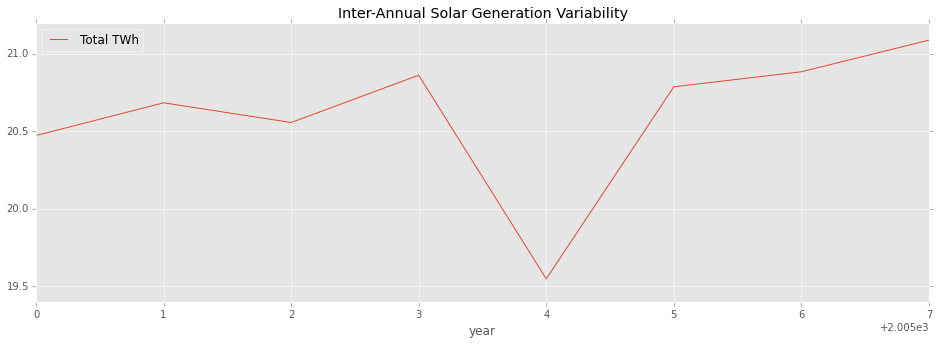

In [16]:
pN = pN[['Total TWh', 'year']]
pN = pN.set_index('year')
_ = pN.plot(figsize=(16,5), title='Inter-Annual Solar Generation Variability')

In [17]:
# calculate p50
import statsmodels.api as sm
ecdf = sm.distributions.ECDF(pN['Total TWh'])

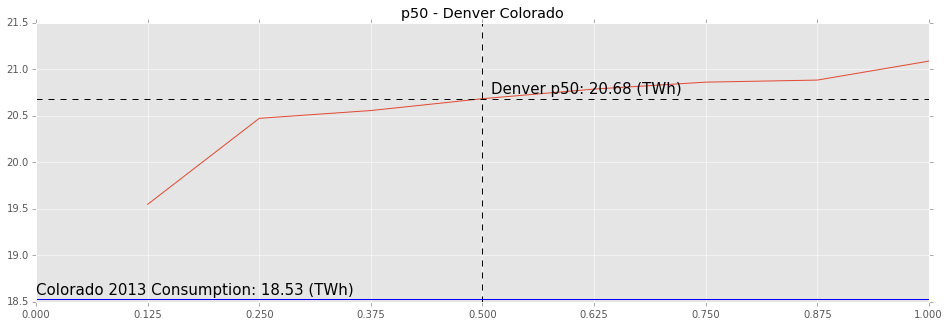

In [18]:
df_ecdf = pd.DataFrame(ecdf.x, index=ecdf.y)
p50 = df_ecdf[df_ecdf.index == 0.5].iloc[0].values
ax = df_ecdf.plot(figsize=(16, 5), legend=False, title='p50 - Denver Colorado')
ax.set_xticks(df_ecdf.index)
plt.axvline(0.5, color='k', ls='--')
plt.axhline(p50, color='k', ls='--')
plt.text(0.51, p50+0.05, 'Denver p50: {v} (TWh)'.format(v=round(p50, 2)), fontsize=15)
hc = eia.iloc[-1]['Historic Consumption (TWh)']
plt.axhline(hc)
plt.text(0, hc + 0.05, 'Colorado 2013 Consumption: {y} (TWh)'.format(y=round(hc, 2)), fontsize=15)

### Need Conclusion

In [19]:
from IPython.display import HTML

In [20]:
HTML('<iframe width="100%" height="520" frameborder="0" src="https://alopez.cartodb.com/viz/a2d2f138-19f6-11e5-b8b3-0e0c41326911/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')